In [4]:
import numpy as np 
from numpy import floor, sqrt
import scipy.sparse.linalg
from matplotlib.gridspec import GridSpec
from math import pi as π
import scipy.sparse as sp
import matplotlib.pyplot as plt
from bosons import (
    construct_basis,
    move_excitation_operator,
    diagonals_with_energies,
    concatenate_bases,
    erase,
)
from waveguide import Waveguide
import sympy as sym
from simulator import Trotter_solver_dynamics
from architecture import Exp_2qubits_2cavities_2purcells
#matplotlib widget

## Phase profile of the two resonances

We know from the theory that when two harmonic oscillators are coupled together their shared frequencies split. In this notebook we want to check wether this is happening in our setup and if the simulation with discrete Waveguide modes matches the theory derived from input-output.

In [5]:
def step_photon(mmax: int) -> np.ndarray: 
    """Creates a flat photon, that is, an equiprobable distribution of all the modes 
    of the waveguide.

    Args:
        mmax (int): number of modes in the WG.

    Returns:
        photon (np.ndarray)
    """
    γ1 = np.ones(mmax+6)
    γ1[:4] = 0
    γ1 = γ1/np.sqrt(mmax)
    return γ1

In [3]:
def flat_photon_scattering(ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913,  g_p=2*π*25e-3, κ2 = 2*π*130e-3,
 length=30, modes=2101):
    
    """computes the scattering of a flat photon that bounces off two 
    coupled harmonic oscillators..

    Args:
        ω1 (int): 
        ω2 (int): 
        g_p (int):
        κ2 (int): 
        length (int): 
        modes (int): 

    Returns:
        WG.frequencies (sp.csr_matrix): Matrix representation of the quantum operator
        phases ():   
    """

    
    WG =  Waveguide( frequency= ω1, modes = modes, length = length )

    control = Exp_2qubits_2cavities_2purcells(ω1 = ω1, ω2 = ω2, g1=0, g2=0,  
                                                 gp1=g_p, gp2=g_p, κ1=0, κ2=κ2,
                                                 waveguide = WG)
    
    duration = 2*WG.tprop
    
    v0 = step_photon(modes)
    
    vt2 = scipy.sparse.linalg.expm_multiply(-1j * duration * control.Hamiltonian(), v0)  
    
    phases = np.angle(step_photon(modes)[6:]*vt2[6:]*np.exp(1j * WG.frequencies * duration))/π
    
    return WG.frequencies, phases, control.κ2*1e-9, control.ω2

In [4]:
κ1 = 2*π*130e-3
g_p=2*π*25e-3

scattering_30m = flat_photon_scattering(g_p=g_p, modes=500)
ω_difference = scattering_30m[0]-scattering_30m[3]

phitheo = np.real(-1j*np.log( ((1j*( ω_difference + g_p )+(κ1/4))) / (1j*(ω_difference +g_p)-(κ1/4)) *     ((1j*(ω_difference - g_p) + (κ1/4))) / (1j*(ω_difference - g_p) - (κ1/4))   ) /π)


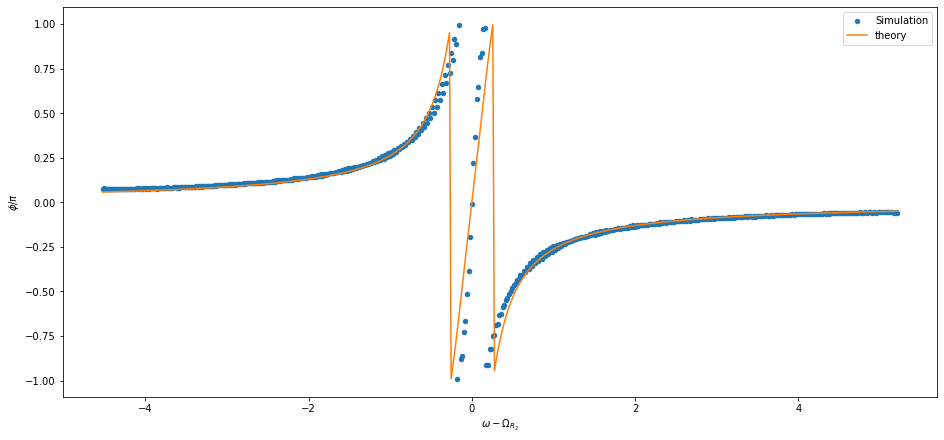

In [5]:
grid = {'hspace': 0.8, 'wspace': 0.5}
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(13, 6), constrained_layout=True)
# plt.rcParams.update({'font.size': 35})

ax1.scatter((scattering_30m[0]-scattering_30m[3]), scattering_30m[1], s=20, color = 'tab:blue', label='Simulation')
ax1.plot((scattering_30m[0]-scattering_30m[3]), phitheo, color = 'tab:orange', label='theory')

ax1.set_xlabel('$\omega - \Omega_{R_2}$')

ax1.set_ylabel('$\phi/\pi$')
ax1.legend()